In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np

In [2]:
X_train = np.load("X_train_tab.npy")
X_val   = np.load("X_val_tab.npy")

y_train = np.load("y_train.npy")
y_val   = np.load("y_val.npy")

idx_train = np.load("idx_train.npy")
idx_val   = np.load("idx_val.npy")

image_filenames = np.load("image_filenames.npy")

In [3]:
image_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

In [4]:
class MultimodalDataset(Dataset):
    def __init__(self, X_tab, y, indices, image_files, img_root):
        self.X_tab = torch.tensor(X_tab, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.indices = indices
        self.image_files = image_files
        self.img_root = img_root

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img_file = self.image_files[self.indices[idx]]
        img_path = os.path.join(self.img_root, img_file)

        image = Image.open(img_path).convert("RGB")
        image = image_tfms(image)

        return image, self.X_tab[idx], self.y[idx]


In [5]:
train_ds = MultimodalDataset(
    X_train, y_train, idx_train,
    image_filenames,
    img_root="data/images/train"
)

val_ds = MultimodalDataset(
    X_val, y_val, idx_val,
    image_filenames,
    img_root="data/images/train"
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

In [6]:
class MultimodalRegressor(nn.Module):
    def __init__(self, tab_dim):
        super().__init__()

        self.cnn = models.resnet18(weights="IMAGENET1K_V1")
        self.cnn.fc = nn.Identity()

        self.tab_net = nn.Sequential(
            nn.Linear(tab_dim, 128),
            nn.ReLU()
        )

        self.regressor = nn.Sequential(
            nn.Linear(512 + 128, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, img, tab):
        img_feat = self.cnn(img)
        tab_feat = self.tab_net(tab)
        x = torch.cat([img_feat, tab_feat], dim=1)
        return self.regressor(x).squeeze()

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = MultimodalRegressor(X_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [8]:
EPOCHS = 12

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for img, tab, y in train_loader:
        img, tab, y = img.to(device), tab.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(img, tab)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train_loader):.4f}")


Epoch 1 | Train Loss: 24.3814
Epoch 2 | Train Loss: 0.1493
Epoch 3 | Train Loss: 0.0845
Epoch 4 | Train Loss: 0.0621
Epoch 5 | Train Loss: 0.0505
Epoch 6 | Train Loss: 0.0445
Epoch 7 | Train Loss: 0.0462
Epoch 8 | Train Loss: 0.0387
Epoch 9 | Train Loss: 0.0363
Epoch 10 | Train Loss: 0.0334
Epoch 11 | Train Loss: 0.0352
Epoch 12 | Train Loss: 0.0290


In [9]:
from sklearn.metrics import mean_squared_error, r2_score

model.eval()
preds, trues = [], []

with torch.no_grad():
    for img, tab, y in val_loader:
        img, tab = img.to(device), tab.to(device)
        pred = model(img, tab)
        preds.extend(pred.cpu().numpy())
        trues.extend(y.numpy())

print("RMSE:", mean_squared_error(trues, preds, squared=False))
print("R²:", r2_score(trues, preds))


RMSE: 0.32051998
R²: 0.6315094034051185


c:\Users\jayja\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [8]:
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [9]:
X_train = np.load("X_train_tab.npy")
X_val   = np.load("X_val_tab.npy")

y_train = np.load("y_train.npy")   
y_val   = np.load("y_val.npy")

In [10]:
tab_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

tab_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, n_estimators=300, random_state=42)

In [11]:
# Predict log-price
log_preds = tab_model.predict(X_val)

# Convert back to price
preds = np.expm1(log_preds)
trues = np.expm1(y_val)

rmse = mean_squared_error(trues, preds, squared=False)
r2   = r2_score(trues, preds)

print("TABULAR MODEL")
print("RMSE:", rmse)
print("R²:", r2)

TABULAR MODEL
RMSE: 132500.18754378735
R²: 0.8919032614306428


c:\Users\jayja\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [14]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [15]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_image, input_tab):
        self.model.zero_grad()
        output = self.model(input_image, input_tab)
        output.backward(torch.ones_like(output))

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)
        cam = cam[0].cpu().detach().numpy()

        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam


In [16]:
# Use last ResNet block
grad_cam = GradCAM(
    model,
    target_layer=model.cnn.layer4
)

c:\Users\jayja\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


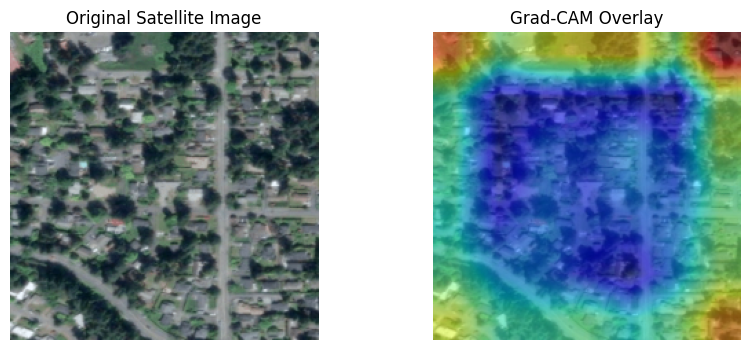

In [17]:
model.eval()

img, tab, y = val_ds[0]

input_img = img.unsqueeze(0).to(device)
input_tab = tab.unsqueeze(0).to(device)

cam = grad_cam.generate(input_img, input_tab)

# Original image
img_np = img.permute(1, 2, 0).numpy()
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("Original Satellite Image")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Grad-CAM Overlay")
plt.imshow(img_np)
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.axis("off")

plt.show()

The Grad-CAM heatmap highlights vegetation cover and open spaces surrounding the property. The model assigns higher importance to green areas, which are commonly associated with improved livability, lower pollution, and higher residential desirability. This suggests that environmental quality captured through satellite imagery contributes positively to the valuation.

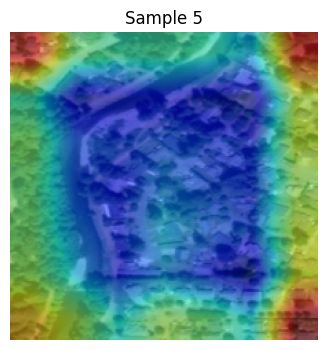

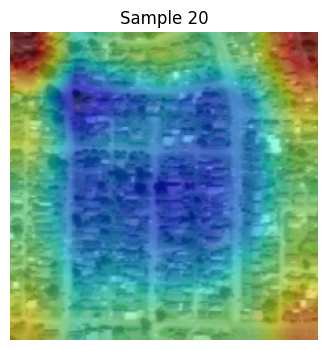

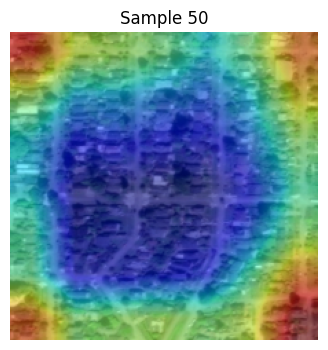

In [18]:
for i in [5, 20, 50]:
    img, tab, _ = val_ds[i]
    input_img = img.unsqueeze(0).to(device)
    input_tab = tab.unsqueeze(0).to(device)
    cam = grad_cam.generate(input_img, input_tab)

    img_np = img.permute(1,2,0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    plt.figure(figsize=(4,4))
    plt.imshow(img_np)
    plt.imshow(cam, cmap="jet", alpha=0.5)
    plt.title(f"Sample {i}")
    plt.axis("off")
    plt.show()

The Grad-CAM overlay demonstrates attention across both built structures and surrounding open spaces. This balanced focus suggests that the model integrates multiple visual cues—such as housing density and neighborhood layout—when estimating property prices, rather than relying on a single dominant visual feature.

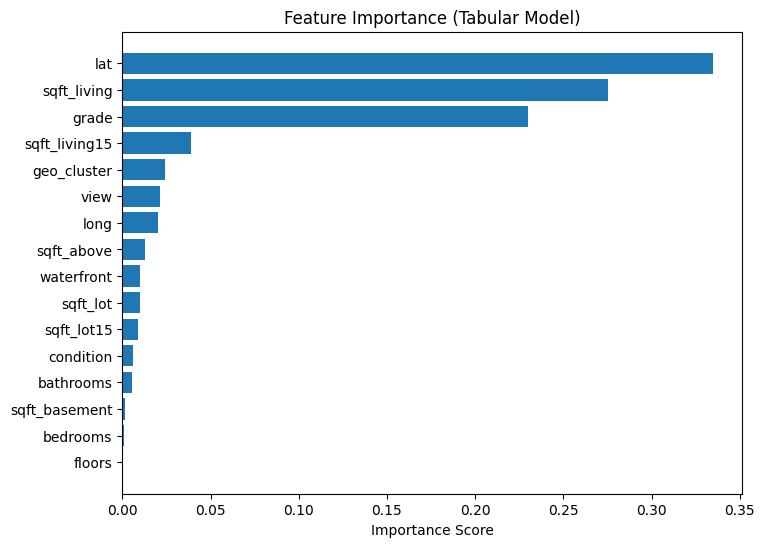

In [19]:
import numpy as np
import matplotlib.pyplot as plt

feature_names = [
    "bedrooms", "bathrooms", "sqft_living", "sqft_lot",
    "floors", "waterfront", "view", "condition", "grade",
    "sqft_above", "sqft_basement",
    "sqft_living15", "sqft_lot15",
    "lat", "long", "geo_cluster"
]

importances = tab_model.feature_importances_

# Sort
idx = np.argsort(importances)

plt.figure(figsize=(8,6))
plt.barh(
    np.array(feature_names)[idx],
    importances[idx]
)
plt.title("Feature Importance (Tabular Model)")
plt.xlabel("Importance Score")
plt.show()

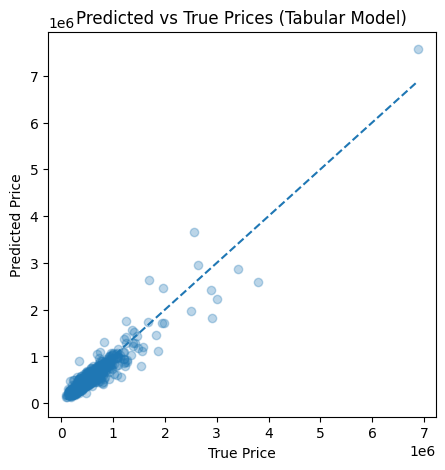

In [20]:
plt.figure(figsize=(5,5))
plt.scatter(trues, preds, alpha=0.3)
plt.plot([trues.min(), trues.max()],
         [trues.min(), trues.max()],
         linestyle="--")
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs True Prices (Tabular Model)")
plt.show()
